In [1]:
import numpy as np
from PIL import Image, ImageDraw
import os
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
import random
from IPython.display import Image as displayImage

### A dataset with one ring and a set of associated properties (center, radius, thickness, and distortion)

In [2]:
img_size = 28

def create_ring(image_size, center, radius, thickness, deformation=0):
    img = Image.new('L', (image_size, image_size), color=0)
    draw = ImageDraw.Draw(img)
    
    for angle in range(360):
        r = radius + random.uniform(-deformation, deformation)
        x = center[0] + r * np.cos(np.radians(angle))
        y = center[1] + r * np.sin(np.radians(angle))
        draw.ellipse([x-thickness/2, y-thickness/2, x+thickness/2, y+thickness/2], fill=255)
    
    return np.array(img)

def generate_dataset(num_images, image_size=img_size, save_dir='ring_regressor_dataset'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    labels = []
    
    for i in range(num_images):
        center = (random.randint(5, image_size-5), random.randint(5, image_size-5))
        radius = random.randint(4, min(center[0], center[1], image_size-center[0], image_size-center[1])-1)
        thickness = random.uniform(0.2, 1.5)#*np.sqrt(radius)
        deformation = random.uniform(0.5, 3)
        
        img = create_ring(image_size, center, radius, thickness, deformation)
        
        img_pil = Image.fromarray(img)
        img_pil.save(f'{save_dir}/ring_image_{i}.png')
        
        # Store the ring properties as a label, now including radius
        label = {
            "center": center,
            "radius": radius,
            "thickness": thickness,
            "deformation": deformation
        }
        labels.append(label)
    
    # Save labels as JSON
    with open(f'{save_dir}/labels.json', 'w') as f:
        json.dump(labels, f, indent=2)

In [3]:
# Generate 10000 images
generate_dataset(10000)
print("Dataset generated successfully!")

Dataset generated successfully!


### Now let's load the data

In [4]:
def load_single_ring_dataset(directory):
    images = []
    labels = []
    
    # Read labels from JSON file
    with open(os.path.join(directory, 'labels.json'), 'r') as f:
        labels_data = json.load(f)
    
    # Load images and process labels
    for i, label in enumerate(labels_data):
        filename = f'ring_image_{i}.png'
        img_path = os.path.join(directory, filename)
        if os.path.exists(img_path):
            # Load and normalize image
            img = Image.open(img_path).convert('L')
            img_array = np.array(img).reshape(-1).astype('float32') / 255
            images.append(img_array)
            
            # Process label
            processed_label = [
                label['center'][0] / img.width,  # Normalize x coordinate
                label['center'][1] / img.height,  # Normalize y coordinate
                label['radius'] / img.width,  # Normalize radius
                label['thickness'],
                label['deformation']
            ]
            labels.append(processed_label)
        else:
            print(f"Warning: Image {filename} not found. Skipping.")
    
    # Ensure we have the same number of images and labels
    if len(images) != len(labels):
        print(f"Warning: Number of images ({len(images)}) does not match number of labels ({len(labels)})")
    
    return np.array(images), np.array(labels)

In [5]:
images, labels = load_single_ring_dataset('single_ring_dataset')

### How does the data look like?

In [6]:
def visualize_ring_dataset(images, labels, num_samples=5, max_cols=4):
    # Ensure we don't try to display more samples than we have
    num_samples = min(num_samples, len(images))
    
    # Randomly select indices
    selected_indices = random.sample(range(len(images)), num_samples)
    
    # Calculate number of rows and columns
    num_cols = min(num_samples, max_cols)
    num_rows = (num_samples - 1) // num_cols + 1
    
    # Calculate figure size (assuming each subplot is 3x3 inches)
    figsize = (num_cols * 3, num_rows * 3)
    
    # Set up the plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if num_rows * num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    img_size = int(np.sqrt(images[0].shape[0]))  # Assuming square images
    
    for i, idx in enumerate(selected_indices):
        ax = axes[i]
        
        # Reshape and display the image
        img = images[idx].reshape((img_size, img_size))
        ax.imshow(img, cmap='gray')
        
        # Extract label information
        center_x, center_y, radius, thickness, deformation = labels[idx]
        
        # Denormalize center coordinates and radius
        center_x *= img_size - 1
        center_y *= img_size - 1
        radius *= img_size - 1
        
        # Add a circle to represent the ring
        circle = Circle((center_x, center_y), radius, fill=False, color='red')
        ax.add_patch(circle)
        
        # Add text with ring properties
        ax.text(0.05, 1.3, f"Center: ({center_x:.1f}, {center_y:.1f})\nRadius: {radius:.1f}\nThickness: {thickness:.2f}\nDeformation: {deformation:.2f}",
                transform=ax.transAxes, verticalalignment='top', color='red', fontsize=10)
        
        ax.axis('off')
    
    # Remove any unused subplots
    for i in range(num_samples, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

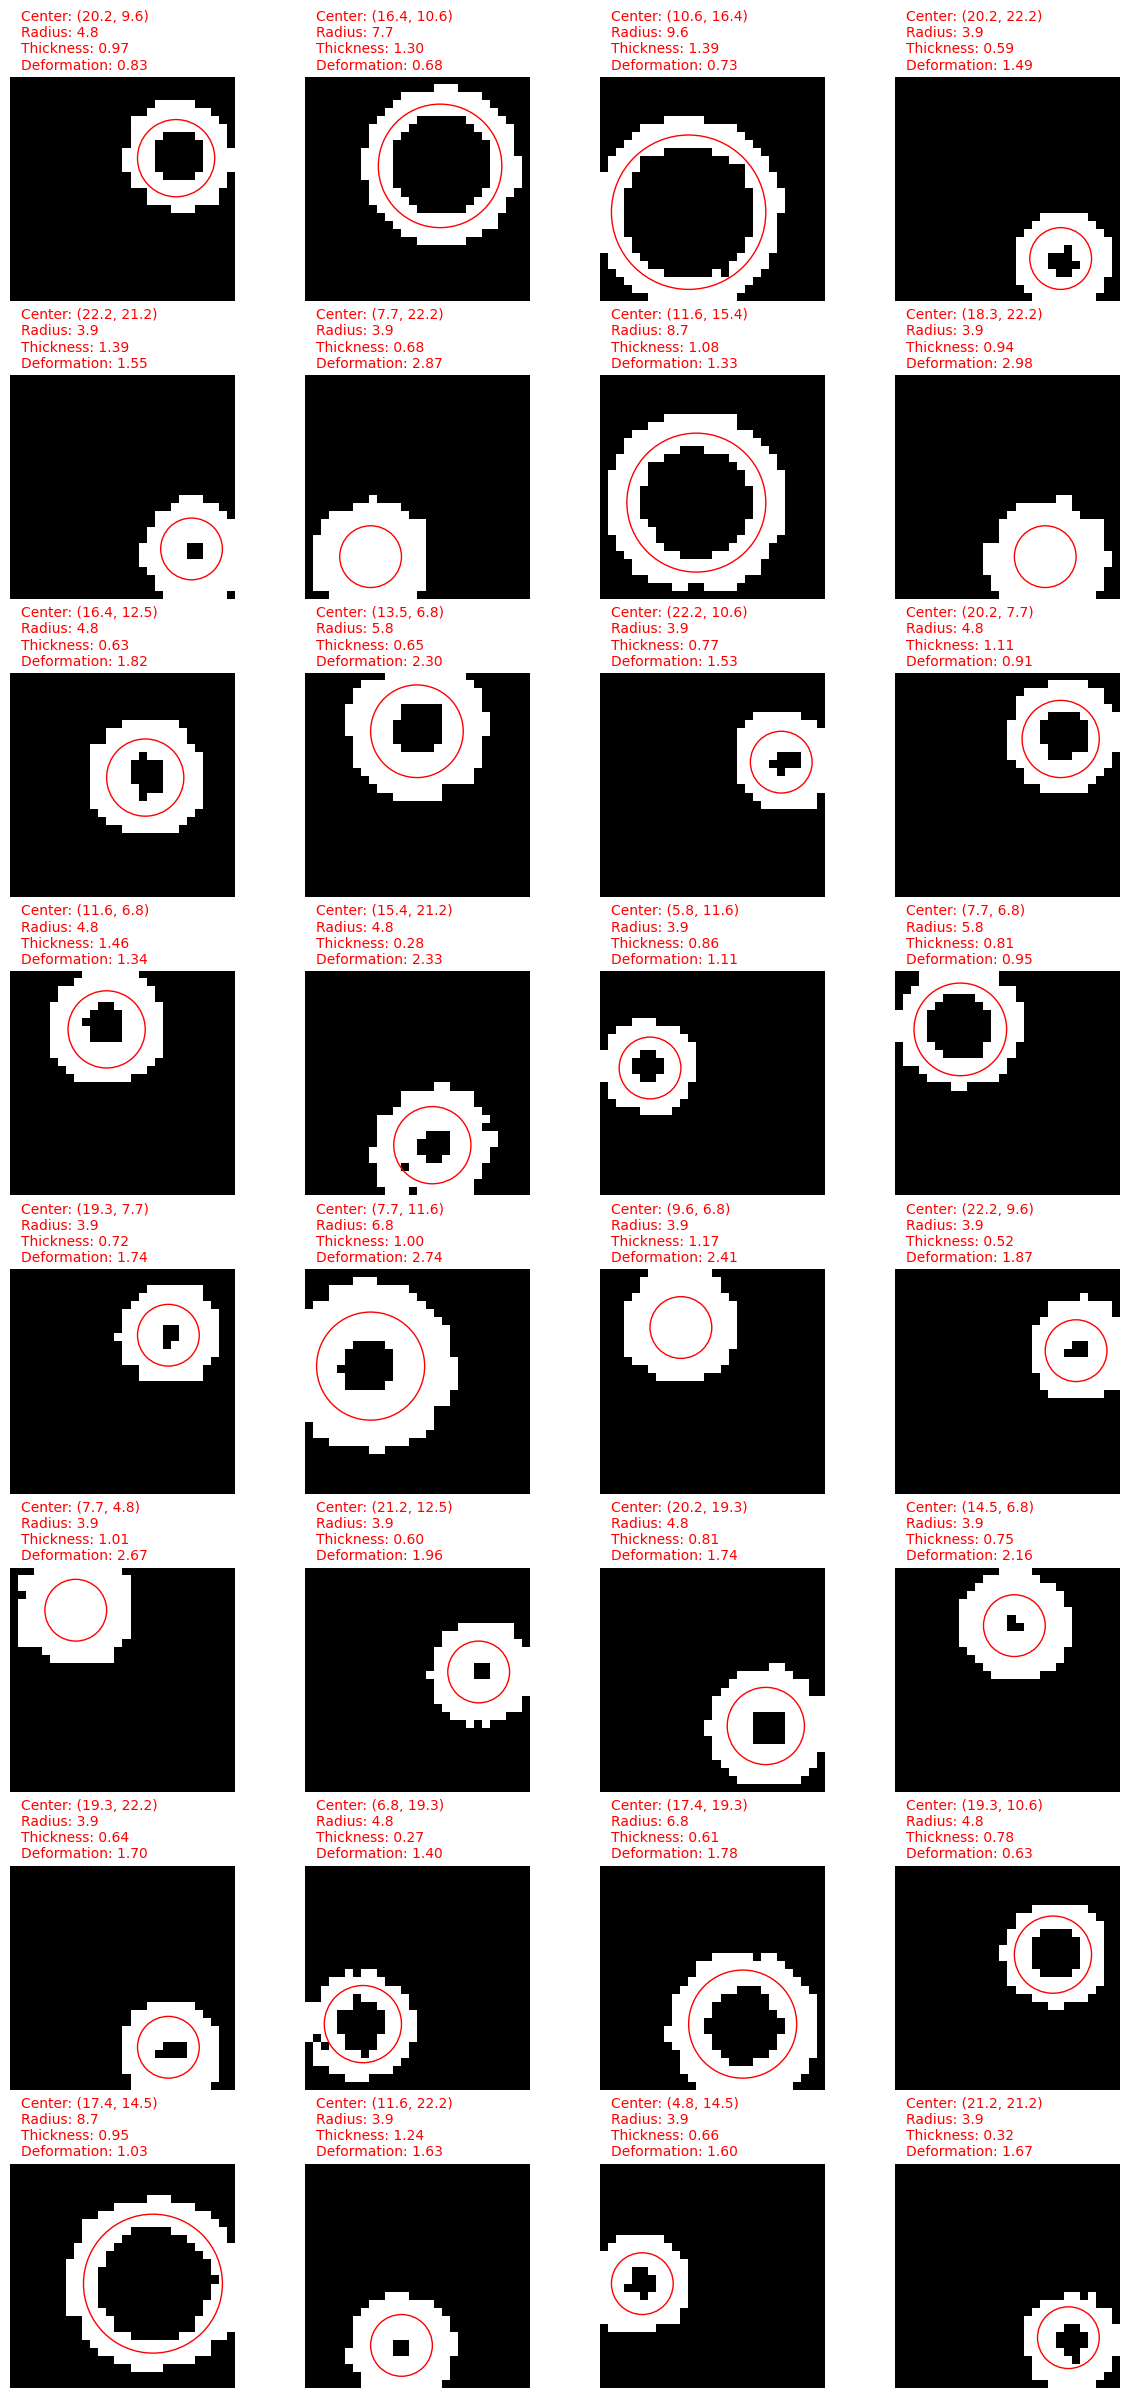

In [7]:
# Visualize some samples
visualize_ring_dataset(images, labels, num_samples=32)

### Can you write some algorithm to perform regression?

I built a solution using a CNN.
Here is how it looked

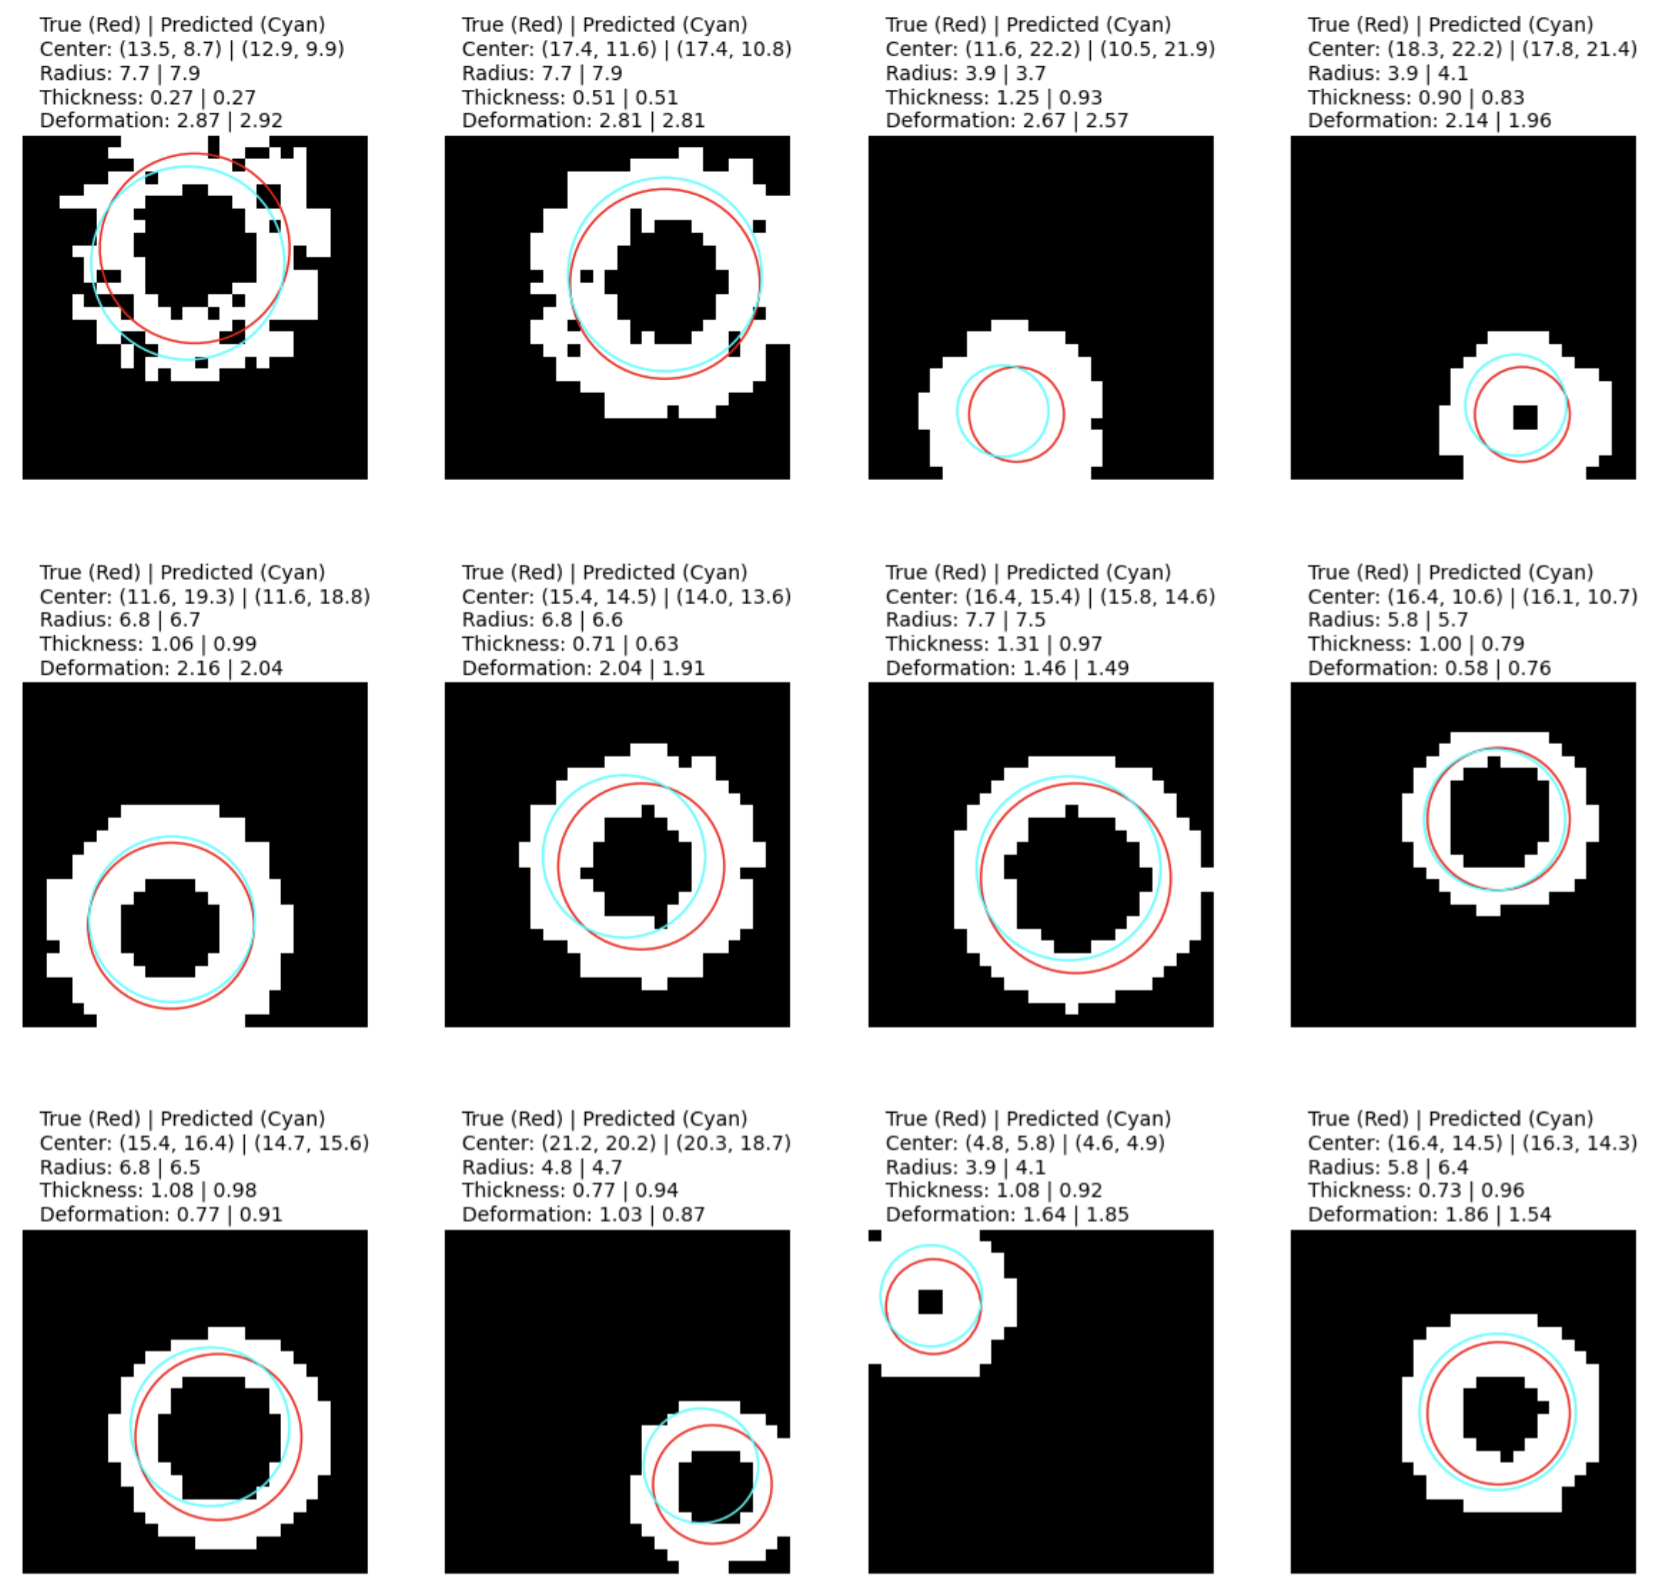

In [21]:
displayImage("tutorial_images/RingRegression.png", width=1140)

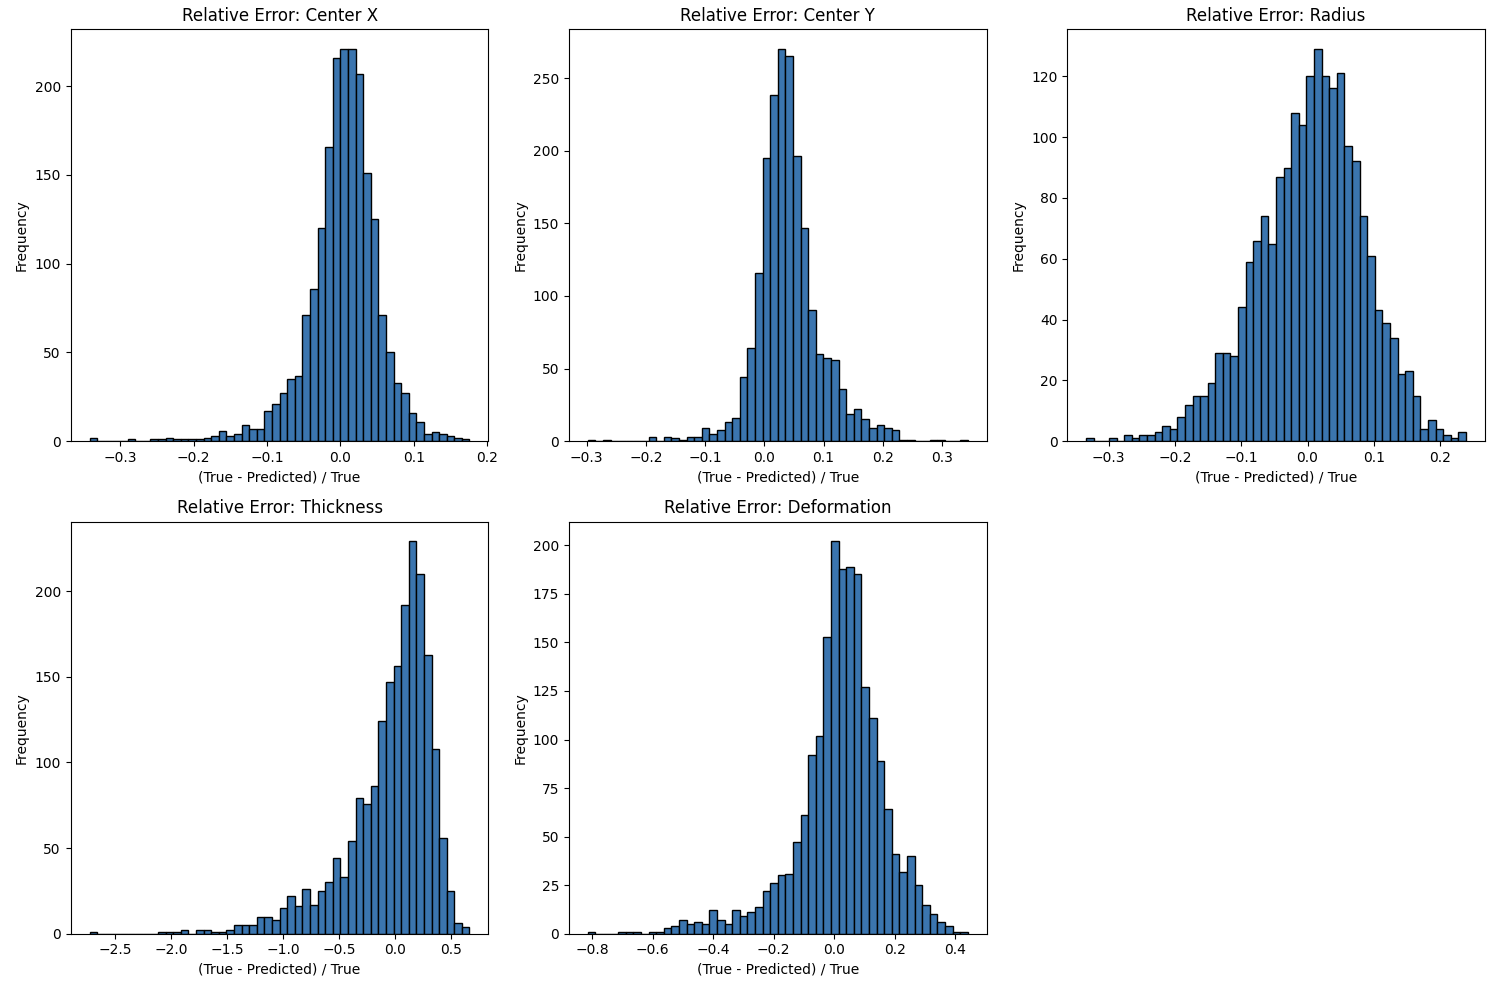

In [15]:
displayImage("tutorial_images/RingRegressionParameterResolutions.png", width=800)

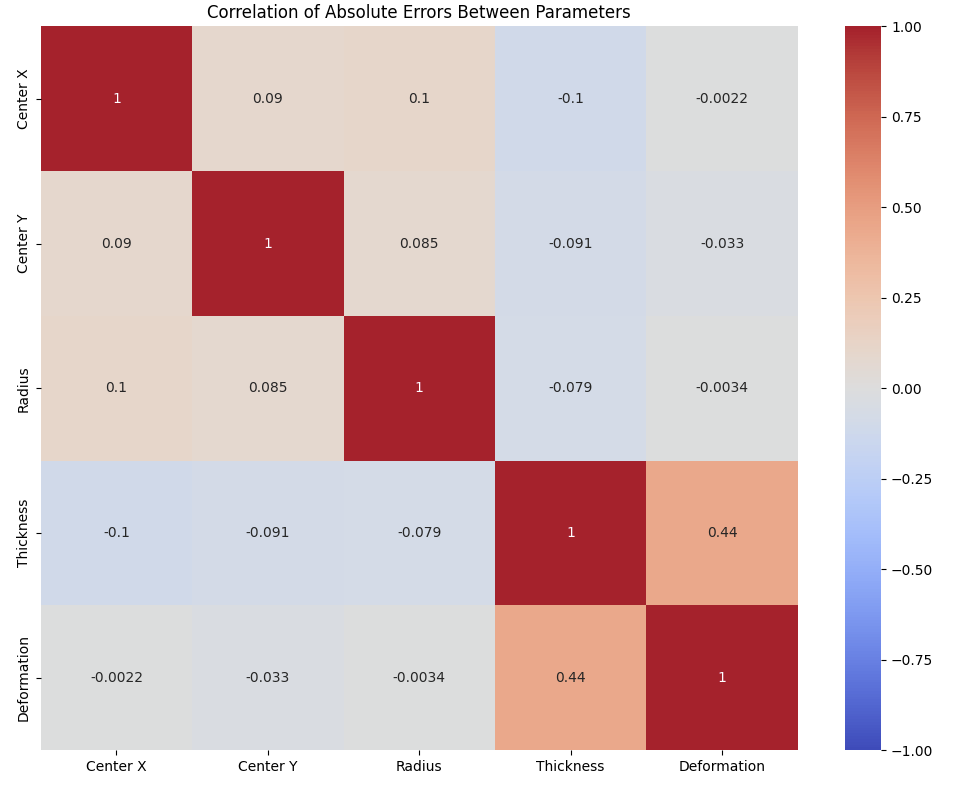

In [16]:
displayImage("tutorial_images/RingRegressionParameterCorrelations.png", width=600)

### If you want to reproduce this plots you will need this auxiliary functions

In [ ]:
def plot_prediction_examples(model, images, labels, img_size, num_samples=5, max_cols=4):
    # Ensure we don't try to display more samples than we have
    num_samples = min(num_samples, len(images))
    
    # Randomly select indices
    selected_indices = random.sample(range(len(images)), num_samples)
    
    # Calculate number of rows and columns
    num_cols = min(num_samples, max_cols)
    num_rows = (num_samples - 1) // num_cols + 1
    
    # Calculate figure size (assuming each subplot is 3x3 inches)
    figsize = (num_cols * 3, num_rows * 4)
    
    # Set up the plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if num_rows * num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Prepare data for prediction
    X = images[selected_indices].reshape(-1, img_size, img_size, 1)
    y_true = labels[selected_indices]
    y_pred = model.predict(X)
    
    for i, idx in enumerate(selected_indices):
        ax = axes[i]
        
        # Reshape and display the image
        img = images[idx].reshape((img_size, img_size))
        ax.imshow(img, cmap='gray')
        
        # Extract true and predicted label information
        true_center_x, true_center_y, true_radius, true_thickness, true_deformation = y_true[i]
        pred_center_x, pred_center_y, pred_radius, pred_thickness, pred_deformation = y_pred[i]
        
        # Denormalize center coordinates and radius
        true_center_x *= img_size - 1
        true_center_y *= img_size - 1
        true_radius *= img_size - 1
        pred_center_x *= img_size - 1
        pred_center_y *= img_size - 1
        pred_radius *= img_size - 1
        
        # Add circles to represent the true and predicted rings
        true_circle = Circle((true_center_x, true_center_y), true_radius, fill=False, color='red', label='True')
        pred_circle = Circle((pred_center_x, pred_center_y), pred_radius, fill=False, color='cyan', label='Predicted')
        ax.add_patch(true_circle)
        ax.add_patch(pred_circle)
        
        # Add text with ring properties (true and predicted)
        ax.text(0.05, 1.35, 
                f"True (Red) | Predicted (Cyan)\n"
                f"Center: ({true_center_x:.1f}, {true_center_y:.1f}) | ({pred_center_x:.1f}, {pred_center_y:.1f})\n"
                f"Radius: {true_radius:.1f} | {pred_radius:.1f}\n"
                f"Thickness: {true_thickness:.2f} | {pred_thickness:.2f}\n"
                f"Deformation: {true_deformation:.2f} | {pred_deformation:.2f}",
                transform=ax.transAxes, verticalalignment='top', fontsize=10)
        
        ax.axis('off')
    
    # Remove any unused subplots
    for i in range(num_samples, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
    
def plot_relative_error_histograms(y_true, y_pred):
    param_names = ['Center X', 'Center Y', 'Radius', 'Thickness', 'Deformation']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, name in enumerate(param_names):
        relative_error = (y_true[:, i] - y_pred[:, i]) / y_true[:, i]
        axes[i].hist(relative_error, bins=50, edgecolor='black')
        axes[i].set_title(f'Relative Error: {name}')
        axes[i].set_xlabel('(True - Predicted) / True')
        axes[i].set_ylabel('Frequency')

    axes[-1].axis('off')  # Remove the last empty subplot
    plt.tight_layout()
    plt.show()

def plot_parameter_correlations(y_true, y_pred):
    param_names = ['Center X', 'Center Y', 'Radius', 'Thickness', 'Deformation']
    
    # Calculate absolute errors
    errors = np.abs(y_true - y_pred)

    # Create correlation matrix
    corr_matrix = np.corrcoef(errors.T)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                xticklabels=param_names, yticklabels=param_names)
    plt.title('Correlation of Absolute Errors Between Parameters')
    plt.tight_layout()
    plt.show()

### Do you want to go one step further? Modify the whole pipeline to introduce a new parameter and learn it!
One idea: Move away from rings and work with ellipses, introducing some exentricity parameter